In [0]:
from google.colab import drive
drive.mount('/content/drive')

**<font size='5' color='black'>Import Library</font>**

In [0]:
#@markdown **<font color='grey'>Click to import and install**
!rm '/content/clustering' -rf
!git clone 'http://www.github.com/Nak007/clustering.git'

!pip install factor-analyzer
import pandas as pd, numpy as np
from clustering import pca_analysis as pca, cluster as cls
import matplotlib.pyplot as plt

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.float_format =  '{:,.2f}'.format

## **<font size='6' color='#0652DD'>&clubs; Factor Analysis</font>**

### **<font color='#0652DD'>( 1 ) Dataset</font>**
---
Simulate dataset from sklearn.datasets.make_blobs

In [0]:
from sklearn.datasets import make_blobs
X, y = make_blobs( n_samples=1000, n_features=8, centers=3, cluster_std=[2.1, 2.8, 4], center_box=(-10,10), random_state=8)
X = pd.DataFrame(X, columns=['feature_{0}'.format(n) for n in range(1,X.shape[1]+1)])

In [8]:
X.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8
0,6.06,10.99,8.57,-1.47,-5.44,-11.23,-0.95,-0.46
1,4.02,0.30,-0.27,-0.16,3.64,2.70,2.12,-0.21
2,-3.33,13.61,-4.87,-9.36,-17.10,10.47,-11.19,-0.03
3,-2.21,-1.36,-3.16,3.98,7.08,5.17,4.43,2.35
4,9.27,8.89,7.25,0.18,-2.52,-11.05,-1.76,-1.06


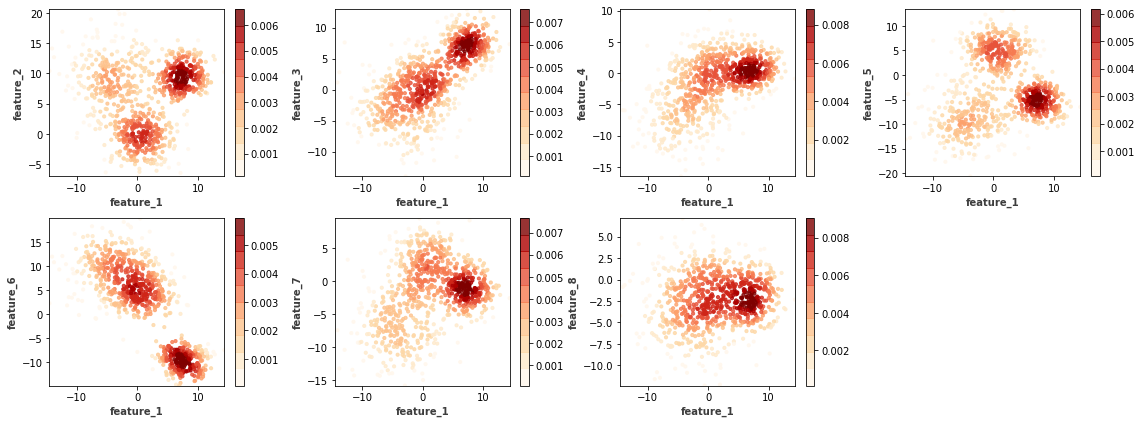

In [9]:
f_plot = pca.plot_factors(0, 0.8, 0, 4)
f_plot.fit(X, 'feature_1', fname=None)

Observe separation of distributions from histogram plots

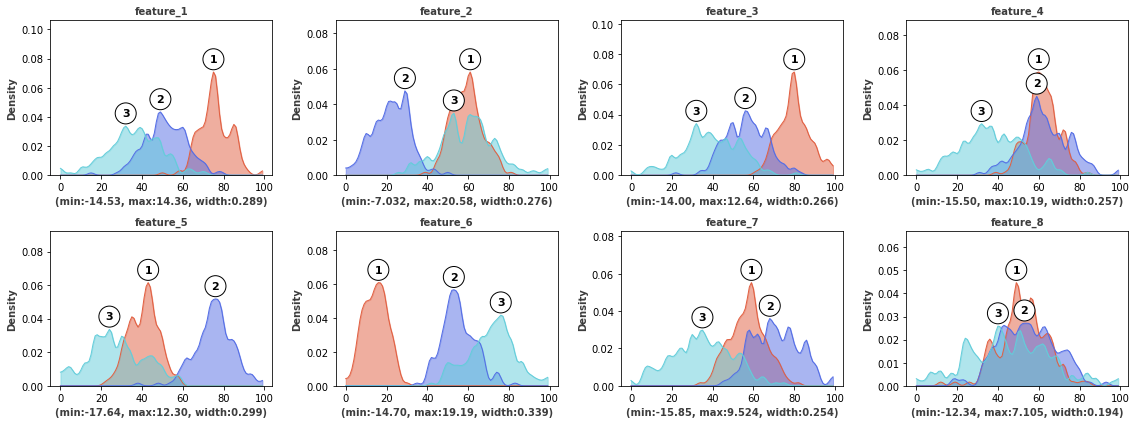

In [10]:
cls.cluster_factors(n_columns=4, frac=0.3).fit(X, y, method='hist',colors=['#e15f41','#546de5','#63cdda'], sigma=1.5, labels='mle')

### **<font color='#0652DD'>( 2 ) Capping Outliers</font>**

In [0]:
m = pca.outliers(method='gamma')
m.fit(X)
capped_X = pd.DataFrame(m.capped_X)

In [0]:
# list of lower and upper bounds
#pd.DataFrame(m.limit_).head()

### **<font color='#*0652DD*'>( 3 ) Standardization</font>**

In [0]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler

In [0]:
# method: {'shift_scale','robust','q_normal','q_uniform'}
X_std = QuantileTransformer(output_distribution='normal').fit_transform(capped_X)
#X_std = StandardScaler().fit_transform(capped_X)
X_std = pd.DataFrame(X_std,columns=list(capped_X))

### **<font color='#0652DD'>( 4.1 ) Principal Component Analysis</font>**

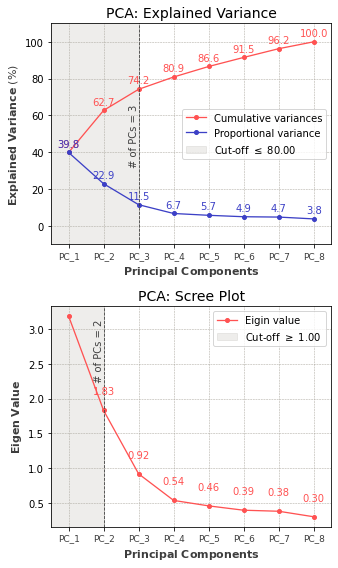

In [15]:
pca_ = pca.principal_components(80,1)
pca_.fit(X_std)
pca_.plot(fname=None)

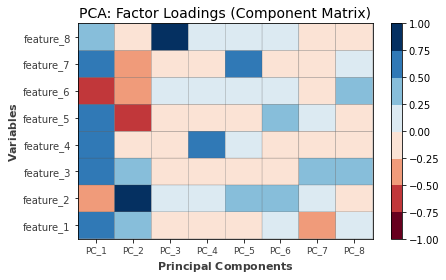

In [16]:
pca_.plot_factor_loadings(fname=None,n_step=8)

In [17]:
pc_score = pca_.transform(X_std, n_comps=8)
pc_score.head(4)

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8
0,2.13,2.33,0.55,-0.46,0.10,-0.00,0.36,-0.09
1,1.80,-1.42,0.39,-0.23,0.09,0.03,-0.30,-0.06
2,-6.29,2.16,1.51,0.13,0.23,-0.33,-0.31,-0.02
3,2.73,-3.49,1.10,0.62,0.40,0.12,-0.08,-0.31


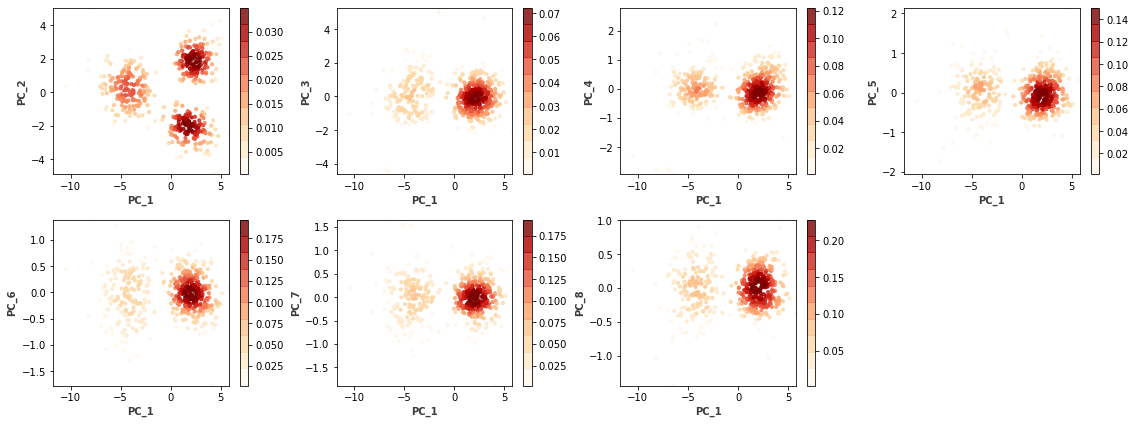

In [18]:
f_plot = pca.plot_factors(0, 0.5, 0, 4)
f_plot.fit(pc_score,'PC_1',fname=None)

### **<font color='#0652DD'>( 4.2 ) Factor Rotation</font>**

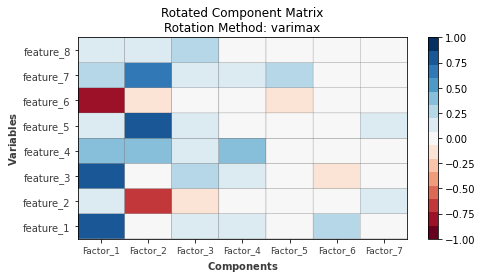

In [19]:
rotated_pc = pca.factor_analysis(X_std.corr()) # try correlation instead of 'pca_.loadings'
rotated_pc.fit(7,'varimax')
rotated_pc.plot(fname=None)

In [20]:
factor_score = rotated_pc.transform(X_std)
factor_score.head(4)

,Factor_1,Factor_2,Factor_3,Factor_4,Factor_5,Factor_6,Factor_7
0,2.87,-0.53,0.44,0.11,0.21,-0.16,0.13
1,0.51,1.92,0.54,0.20,0.20,0.13,-0.03
2,-3.44,-5.02,-1.23,-1.04,-0.43,0.06,-0.16
3,-0.10,3.75,0.95,0.63,0.31,0.06,-0.05


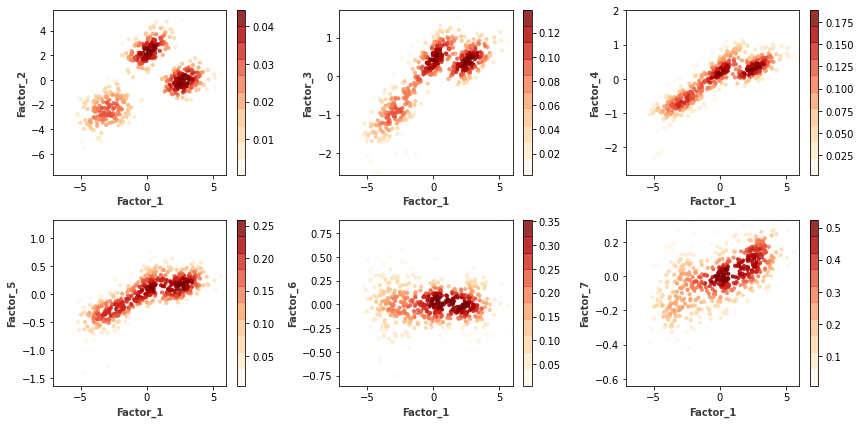

In [21]:
f_plot = pca.plot_factors(0, 0.5, 0, 3)
f_plot.fit(factor_score, 'Factor_1', fname=None)

### **<font color='#0652DD'>( 5 ) Factor Analysis Dataset</font>**

In [0]:
kwargs = dict(how='left', left_index=True, right_index=True)
df = capped_X.merge(pc_score,**kwargs).merge(factor_score,**kwargs)

## **<font size="6" color='#009432'>&spades; Clustering with PCA</font>**

Select features ==> Principal Components

In [0]:
#features = df.columns[df.columns.str.contains('PC')]
features = ['PC_1','PC_2']

### **<font color='#009432'>( 1.1 ) KMeans Clustering</font>**

In [0]:
k_pca = cls.cluster_kmeans(p_samples=0.5,n_bootstraps=50,**dict(random_state=99))
k_pca.fit(df[features])

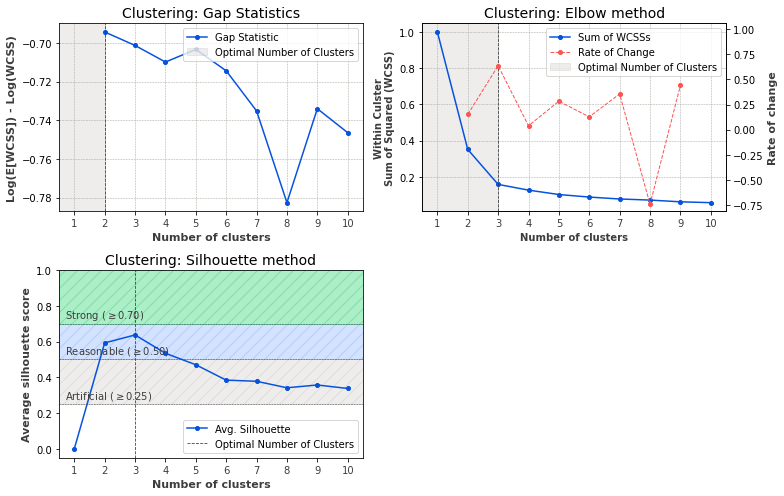

In [25]:
cls.cluster_results(k_pca.data)

### **<font color='#009432'>( 1.2 ) Hierarchical clustering</font>**

In [0]:
h_pca = cls.cluster_linkage()
h_pca.fit(df[features])

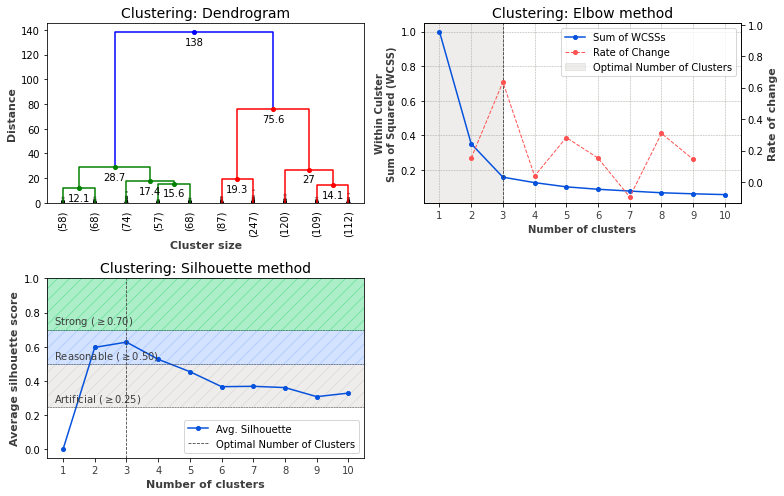

In [27]:
cls.cluster_results(h_pca.data)

### **<font color='#009432'>( 2 ) Clustering Analysis</font>**

In [0]:
# Select labels from KMeans
labels = k_pca.data['labels'][:,2]
colors = cls.matplotlib_cmap('coolwarm_r',np.unique(labels).shape[0])

#### **<font color='#009432'>( 2.1 ) Pie chart</font>**
---
Proportion of respective clusters

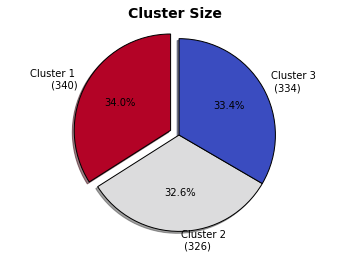

In [29]:
fig, axis = plt.subplots()
cls.cluster_pie(axis, labels, colors=colors)
axis.set_title('Cluster Size',fontsize=14, fontweight='bold')
plt.show()

#### **<font color='#009432'>( 2.2 ) Radar chart</font>**
---
Observe differences among clusters

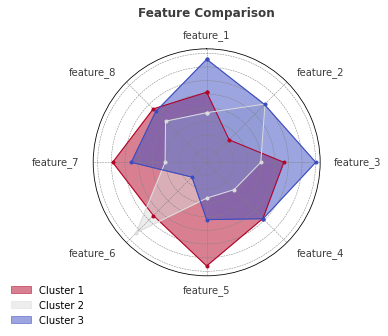

In [30]:
r1 = cls.radar_plot(**dict(marker='o', ms=3))
c = [n for n in list(df) if str(n).find('feature')>-1]
r1.fit(df[c], labels, q=50, title='Feature Comparison\n')

#### **<font color='#009432'>( 2.3 ) Scatter chart</font>**
---
Use pairwise comparison to observe interaction of variables

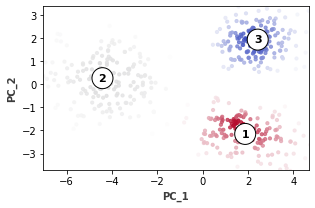

In [31]:
p1 = cls.cluster_factors(n_columns=4, frac=0.3)
p1.fit(df[features], labels, alpha=1, method='scatter',colors=colors, labels='centroid')

#### **<font color='#009432'>( 2.4 ) PDF chart</font>**
---
Use Probability Density as well as Maximum Likelihood Estimators to oberve how each cluster form its own distribution 

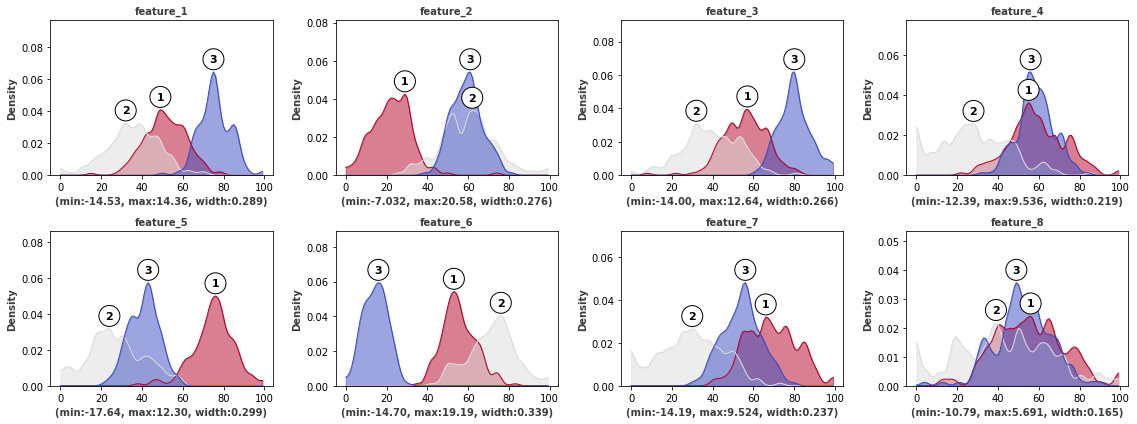

In [32]:
c = [n for n in list(df) if str(n).find('feature')>-1]
p1.fit(df[c], labels, method='hist', sigma=2, colors=colors, labels='mle')

## **<font size="6" color='#ED4C67'>&hearts; Clustering with Factor Rotation</font>**

Select features ==> Factor

In [0]:
#features = df.columns[df.columns.str.contains('Factor')]
features = ['Factor_1','Factor_2']

### **<font color='#ED4C67'>( 1.1 ) KMeans Clustering</font>**

In [0]:
k_factor = cls.cluster_kmeans(p_samples=0.2,n_bootstraps=100,**dict(random_state=10))
k_factor.fit(df[features])

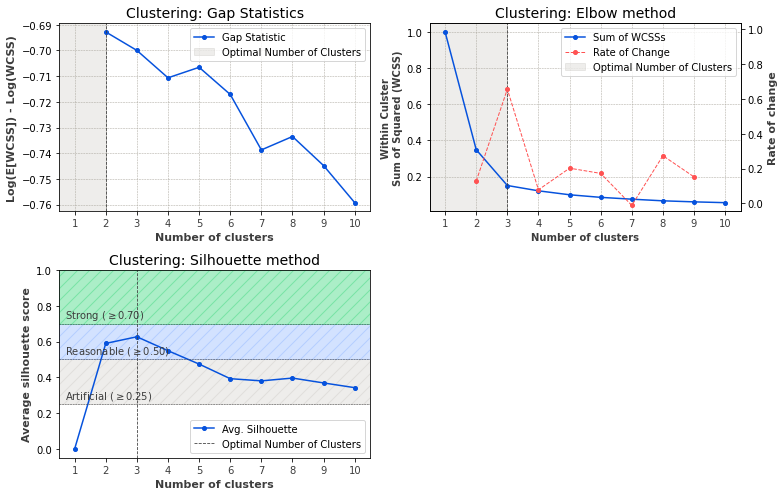

In [35]:
cls.cluster_results(k_factor.data)

### **<font color='#ED4C67'>( 1.2 ) Hierarchical clustering</font>**

In [0]:
h_factor = cls.cluster_linkage()
h_factor.fit(df[features])

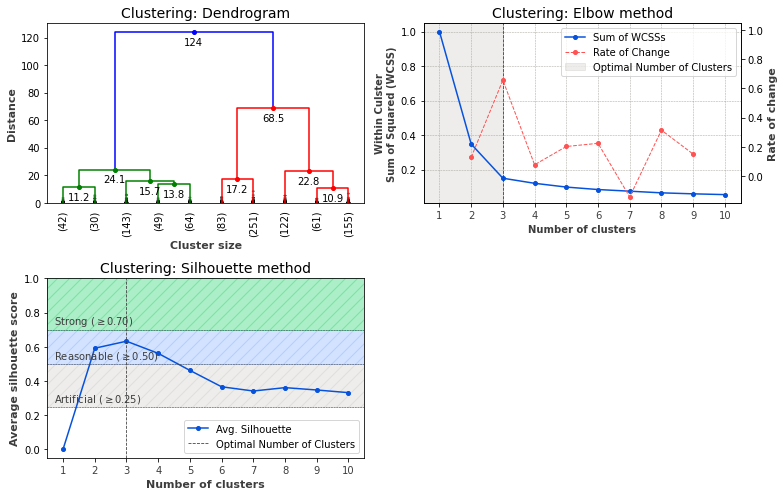

In [37]:
cls.cluster_results(h_factor.data)

### **<font color='#ED4C67'>( 2 ) Clustering Analysis</font>**

In [0]:
labels = k_factor.data['labels'][:,2]
colors = cls.matplotlib_cmap('coolwarm_r',np.unique(labels).shape[0])

#### **<font color='#ED4C67'>( 2.1 ) Pie chart</font>**
---
Proportion of respective clusters

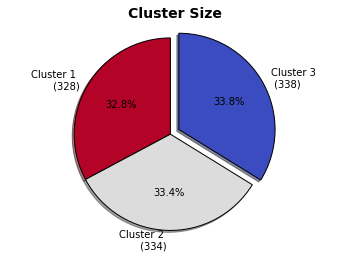

In [39]:
fig, axis = plt.subplots()
cls.cluster_pie(axis, labels, colors=colors)
axis.set_title('Cluster Size',fontsize=14, fontweight='bold')
plt.show()

#### **<font color='#ED4C67'>( 2.2 ) Radar chart</font>**
---
Observe differences among clusters

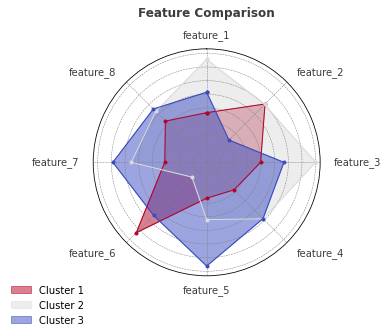

In [40]:
r1 = cls.radar_plot(**dict(marker='o', ms=3))
c = [n for n in list(df) if str(n).find('feature')>-1]
r1.fit(df[c], labels, q=50, title='Feature Comparison\n')

#### **<font color='#ED4C67'>( 2.3 ) Scatter chart</font>**
---
Use pairwise comparison to observe interaction of variables

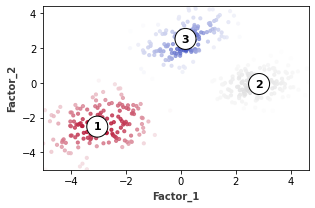

In [41]:
p1 = cls.cluster_factors(n_columns=4, frac=0.3)
p1.fit(df[features], labels, alpha=1, method='scatter',colors=colors, labels='centroid')

#### **<font color='#ED4C67'>( 2.4 ) PDF chart</font>**
---
Use Probability Density as well as Maximum Likelihood Estimators to oberve how each cluster form its own distribution 

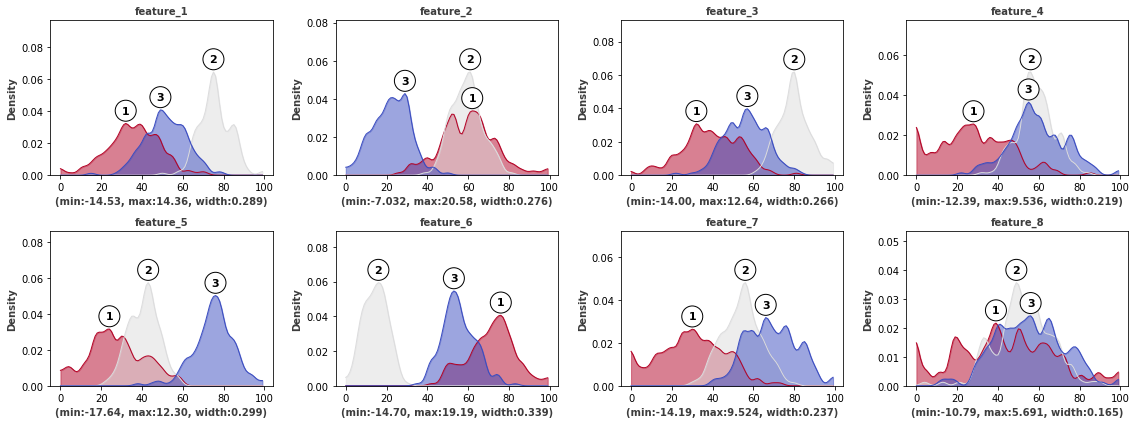

In [42]:
c = [n for n in list(df) if str(n).find('feature')>-1]
p1.fit(df[c], labels, method='hist', sigma=2, colors=colors, labels='mle')

## **<font size="5" color='#576574'>Final Cluster</font>**
---
Select parameters and method that best answer business interpretation and practicality

In [0]:
# we select 3 clusters
df['pca_cluster'] = k_pca.data['labels'][:,2]
df['fac_cluster'] = k_factor.data['labels'][:,2]
#df.to_csv('/content/drive/My Drive/Colab Notebooks/clustering.txt',sep='|',index=False)

## **<font size="6" color='black'>&diams; Anomaly Detection</font>**

In [0]:
# we select cluster 2 fron KMeans with PCA
data = df.loc[df['pca_cluster']==1]

In [0]:
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5','PC_6','PC_7','PC_8']
lof = cls.local_outlier(data[columns])

In [0]:
threshold = lof['threshold']
anomaly = (lof['scores']>threshold).astype(int)

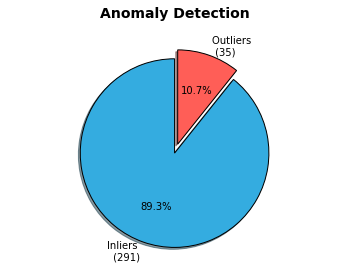

In [123]:
fig, axis = plt.subplots()
cls.cluster_pie(axis, anomaly, colors=['#34ace0','#ff5e57'], labels=['Inliers','Outliers'])
axis.set_title('Anomaly Detection\n',fontsize=14, fontweight='bold')
plt.show()

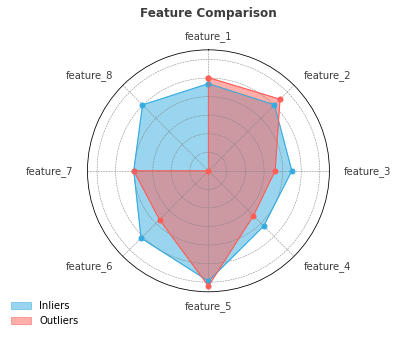

In [124]:
r1 = cls.radar_plot(**dict(marker='o', ms=5))
c = [n for n in list(df) if str(n).find('feature')>-1]
r1.fit(data[c], anomaly, q=50, title='Feature Comparison\n', 
       colors=['#34ace0','#ff5e57'], labels=['Inliers','Outliers'])

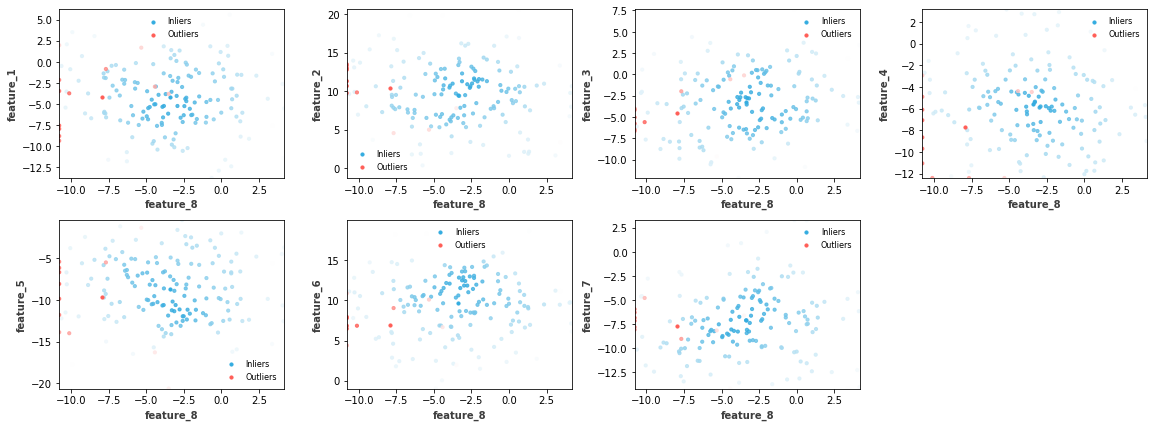

In [125]:
p1 = cls.cluster_factors(n_columns=4, frac=1)
p1.fit(data[c], anomaly, factor='feature_8', method='scatter', 
       colors=['#34ace0','#ff5e57'], labels=['Inliers','Outliers'])